In [1]:
import networkx as nx
import random
import numpy as np
import matplotlib.pyplot as plt

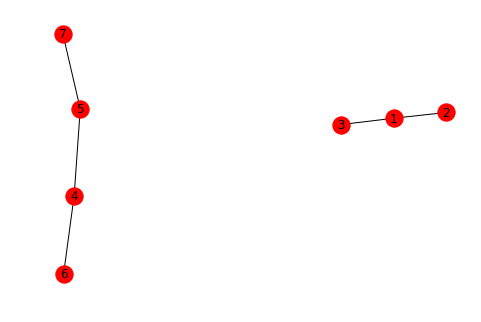

In [2]:
g = nx.empty_graph()
g.add_edges_from([(1,2), (1,3), (4,5), (4,6), (5,7)])
nx.draw(g, with_labels=True)

In [3]:
# generator
comp = nx.connected_components(g)
list(comp)

[{1, 2, 3}, {4, 5, 6, 7}]

In [4]:
def get_component_size_dist(net):
    """Calculates the (unnormalised) component size distribution of a network.

    For example, if the input network has 1 component of size 5 nodes and
    3 components of size 10 nodes, then this function will return a dictionary:
    {5:1, 10:3}.
    {size: count,}

    Parameters
    ----------
    net : networkx.Graph object

    Returns
    -------
    Dictionary where keys are component sizes and values are the number of
    components of that size.
    """
    dist = {}
    
    
    components = nx.connected_components(g)
    for each_comp in components:
        size = len(each_comp)
        if size in dist:
            dist[size] += 1
        else:
            dist[size] = 1
    
    return dist

In [5]:
get_component_size_dist(g)

{3: 1, 4: 1}

In [6]:
def get_largest_component_size(component_size_distribution):
    """Finds the largest component in the given component size distribution.

    Parameters
    ----------
    component_size_distribution : dict
       The component size distribution. See the function get_component_size_dist

    Returns
    -------
    The largest component size : int
    """
    dist = component_size_distribution
    max_size = max(dist.keys())
    return max_size

In [7]:
get_largest_component_size({1:5, 2:4, 3:10, 4:5})

4

In [8]:
def create_er_network(net_size, avg_degree):
    """Creates a realisation of an Erdos-Renyi network.

    Parameters
    ----------
    net_size : int
       Number of nodes in the network.
    avg_degree : float
       The value of edge probability p is set such that this is the
       expected average degree in the network.

    Returns
    -------

    net: a network object

    """
    p = avg_degree / (net_size - 1)
    net = nx.fast_gnp_random_graph(n=net_size, p=p)
    return net

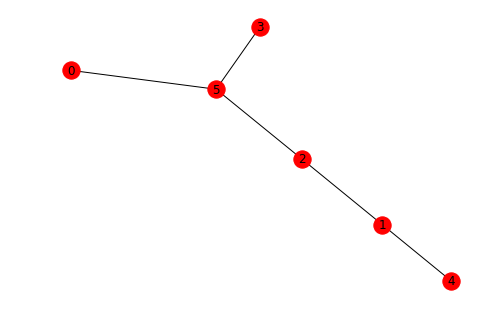

In [9]:
er = create_er_network(6, 2)
nx.draw(er, with_labels=True)

In [10]:
def calculate_loop_edge_fraction(network, visited_nodes, boundary_nodes):
    """ Calculates the number of edges that go from the boundary to already visited nodes
    in addition to the number of edges that is expected if the network would be a tree.
    This number is then divided by the number of edges in total that go from the boundary
    to the visited nodes.

    In the case that the there are zero edges from the boundary to the visited nodes,
    this function returns zero (i.e., in the beginning when the boundary set is the same
    as the visited nodes).

    Parameters
    ----------
    network : networkx.Graph object
    visited_nodes : set object
      The set of nodes that are visited (including the boundary)
    boundary_nodes : set object
      The set of nodes that are in the boundary, i.e., the were visited in the last iteration.

    Returns
    -------
    The fraction described above : float

    """
    if len(visited_nodes) == 1:
        return 0

    edge_count = 0

    for node in boundary_nodes:
        for neighbor in network[node]:
            if neighbor in visited_nodes or neighbor in boundary_nodes:
                edge_count += 1

    if edge_count != 0:
        loop_count = edge_count -len(boundary_nodes)
        assert loop_count >= 0
        return loop_count/float(edge_count)
    else:
        return 0

In [11]:
def expand_breadth_first_search(network, visited_nodes, boundary_nodes):
    """Performs one step in a breadth first search and updates the visited nodes
    and boundary nodes sets that are given as parameters accordingly. Here one
    step means that we will find all nodes that are one step further away from
    the starting node. These nodes will form the new boundary.

    Parameters
    ----------
    network : networkx.Graph object
    visited_nodes : set object
      The set of nodes that are visited (including the boundary)
    boundary_nodes : set object
      The set of nodes that are in the boundary, i.e., the were visited in the last iteration.

    Returns
    -------
    Nothing, the visited nodes an boundary nodes are update in place.

    """

    new_boundary = set() # Nodes in the new boundary are added here

    # Go through all the nodes in the boundary, and add their neighbors
    # that are not visited to the new boundary. Remember to update
    # the visited_nodes as you go.
    for node in boundary_nodes:
        for nn in network.neighbors(node):
            if nn not in visited_nodes:
                new_boundary.add(nn)
                visited_nodes.add(nn)

    # Here we replace the old boundary with the new boundary
    boundary_nodes.clear()
    boundary_nodes.update(new_boundary)
    
    # void
    # We return nothing as the results were updated to visited_nodes and boundary_nodes

In [12]:
"""Creates a figure of breadth first search in an ER network.

Parameters
----------
avg_degree : float
  The expected degree of the nodes in the ER network
net_size : int
  The number of nodes in the ER network
number_of_samples : int
   The number of randomly selected starting node for the BFS
max_depth : int
   The maximum depth of the BFS
"""
    
avg_degree = 0.5
net_size = 10**4
number_of_samples = 10000
max_depth=15

In [13]:
net = create_er_network(net_size, avg_degree)

In [14]:
# We will count the number of nodes and the loop fraction for each depth and each
# starting node. That is, we need a 2-dimensional list to save these results.
# The element node_count[depth][sample_number] gives the number of nodes at the boundary
# of the BFS at the given depth for given sample number.
# The code below will create lists of length max_depth where each element is an empty list.
node_count = [[] for depth in range(max_depth+1)]
loop_edge_fraction = [[] for depth in range(max_depth+1)]

# Next we will run the BFS until max_depth for each randomly selected sample
for _sample_nr in range(number_of_samples):
    # Choose random starting node:
    start_node = random.randint(0, net_size-1)
    # In the beginning we have only visited the start node:
    visited_nodes = set([start_node])
    # The start node is also the only boundary node, see expand_breadth_first_search:
    boundary_nodes = set([start_node])

    for depth in range(max_depth+1):
        number_of_boundary_nodes = len(boundary_nodes)

        fraction_of_loop_edges = calculate_loop_edge_fraction(net,
                                                              visited_nodes, boundary_nodes)

        # Update the visited nodes and the boundary
        expand_breadth_first_search(net, visited_nodes, boundary_nodes)

        # Saving the results
        node_count[depth].append(number_of_boundary_nodes)
        loop_edge_fraction[depth].append(fraction_of_loop_edges)

In [15]:
# Averaging over the different starting nodes.
avg_node_count = list(map(np.mean, node_count))
avg_loop_edge_fraction = list(map(np.mean, loop_edge_fraction))

# Calculating the theoretical values, assuming the network is a tree
avg_node_count_theoretical = []
for depth in range(max_depth+1):
    # Replace with the formula from 
    # calculate the expected number of nodes at d steps away,  
    #  n_d from a randomly selected node in an ER network
    k = avg_degree
    d = depth
    if k<2:
        n = 0
    else:
        n = k/(k-1) * (k - 1)**(d)
    avg_node_count_theoretical.append(n)

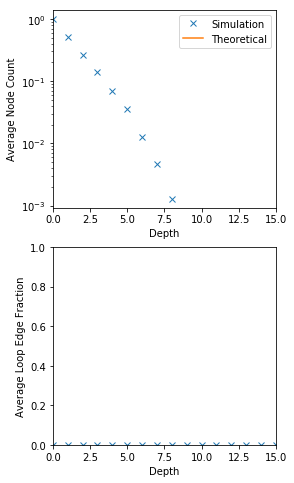

In [16]:
#Plotting the results
fig = plt.figure(figsize=(4, 8))
ax1 = fig.add_subplot(211)

ax1.semilogy(list(range(max_depth+1)), avg_node_count, "x", label="Simulation")
ax1.semilogy(list(range(max_depth+1)), avg_node_count_theoretical, label="Theoretical")

# ax1.semilogy([0, max_depth], 2*[net_size], "k--")

ax1.set_xlabel("Depth") # Set proper axis labels!
ax1.set_ylabel("Average Node Count") # Set proper axis labels!
ax1.set_xlim(0, max_depth)
ax1.legend()


ax2 = fig.add_subplot(212)
ax2.plot(list(range(max_depth+1)), avg_loop_edge_fraction, "x", label="Simulation")
ax2.set_xlabel("Depth") # Set proper axis labels!
ax2.set_ylabel("Average Loop Edge Fraction") # Set proper axis labels!
ax2.set_xlim(0, max_depth)
ax2.set_ylim(0, 1)

plt.show()

In [17]:
def ER_breadth_first_search(avg_degree, net_size, number_of_samples,
                            max_depth=15, show_netsize=False):
    """Creates a figure of breadth first search in an ER network.

    Parameters
    ----------
    avg_degree : float
      The expected degree of the nodes in the ER network
    net_size : int
      The number of nodes in the ER network
    number_of_samples : int
       The number of randomly selected starting node for the BFS
    max_depth : int
       The maximum depth of the BFS
    show_netsize : bool
       If True, we will plot the size of the network in the first panel as a dotter horizontal line.

    Returns
    -------
    fig : figure object
    """
    net = create_er_network(net_size, avg_degree)

    # We will count the number of nodes and the loop fraction for each depth and each
    # starting node. That is, we need a 2-dimensional list to save these results.
    # The element node_count[depth][sample_number] gives the number of nodes at the boundary
    # of the BFS at the given depth for given sample number.
    # The code below will create lists of length max_depth where each element is an empty list.
    node_count = [[] for depth in range(max_depth+1)]
    loop_edge_fraction = [[] for depth in range(max_depth+1)]

    # Next we will run the BFS until max_depth for each randomly selected sample
    for _sample_nr in range(number_of_samples):
        # Choose random starting node:
        start_node = random.randint(0, net_size-1)
        # In the beginning we have only visited the start node:
        visited_nodes = set([start_node])
        # The start node is also the only boundary node, see expand_breadth_first_search:
        boundary_nodes = set([start_node])

        for depth in range(max_depth+1):

            number_of_boundary_nodes = len(boundary_nodes)

            fraction_of_loop_edges = calculate_loop_edge_fraction(net,
                                                                  visited_nodes, boundary_nodes)

            # Update the visited nodes and the boundary
            expand_breadth_first_search(net, visited_nodes, boundary_nodes)

            # Saving the results
            node_count[depth].append(number_of_boundary_nodes)
            loop_edge_fraction[depth].append(fraction_of_loop_edges)

    # Averaging over the different starting nodes.
    avg_node_count = list(map(np.mean, node_count))
    avg_loop_edge_fraction = list(map(np.mean, loop_edge_fraction))

    # Calculating the theoretical values, assuming the network is a tree
    avg_node_count_theoretical = []
    for depth in range(max_depth+1):
        # Replace with the formula from 
        # calculate the expected number of nodes at d steps away,  
        #  n_d from a randomly selected node in an ER network
        k = avg_degree
        d = depth
        n = k**d
        avg_node_count_theoretical.append(n)

    #Plotting the results
    fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(10,4))

    
    ax1, ax2 = axes
    plt.suptitle(f'Average degree:{avg_degree} Netsize:{net_size}')

    ax1.semilogy(list(range(max_depth+1)), avg_node_count, "x", label="Simulation")
    ax1.semilogy(list(range(max_depth+1)), avg_node_count_theoretical, label="Theoretical")

    if show_netsize:
        ax1.semilogy([0, max_depth], 2*[net_size], "k--")

    ax1.set_xlabel("Depth") # Set proper axis labels!
    ax1.set_ylabel("Average Node Count") # Set proper axis labels!
    ax1.set_xlim(0, max_depth)
    ax1.legend()


    ax2.plot(list(range(max_depth+1)), avg_loop_edge_fraction, "x", label="Simulation")
    ax2.set_xlabel("Depth") # Set proper axis labels!
    ax2.set_ylabel("Average Loop Edge Fraction") # Set proper axis labels!
    ax2.set_xlim(0, max_depth)
    ax2.set_ylim(0, 1)

    plt.show() # uncomment if you want to display the figure on the screen

    return fig

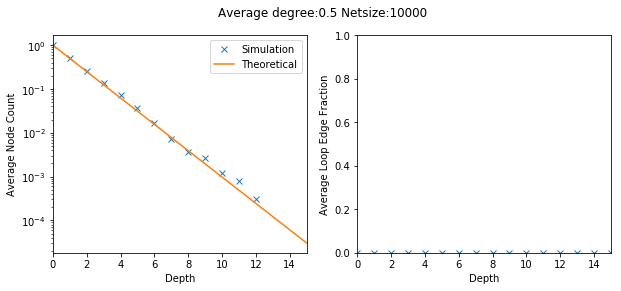

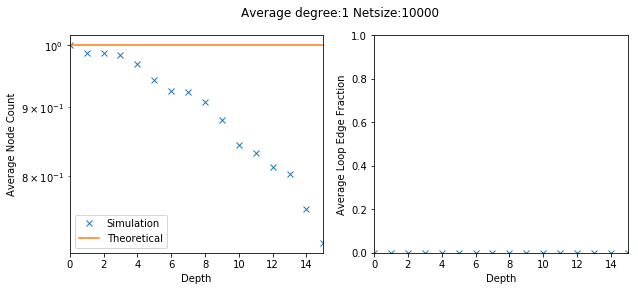

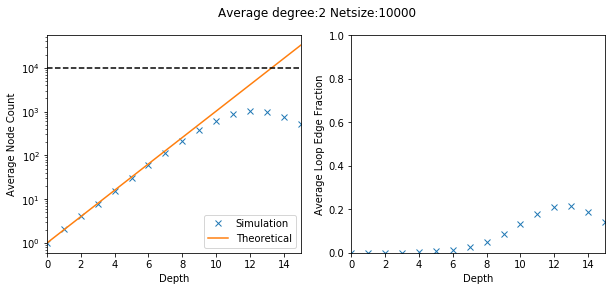

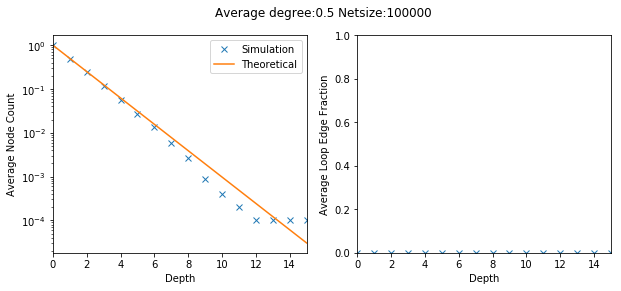

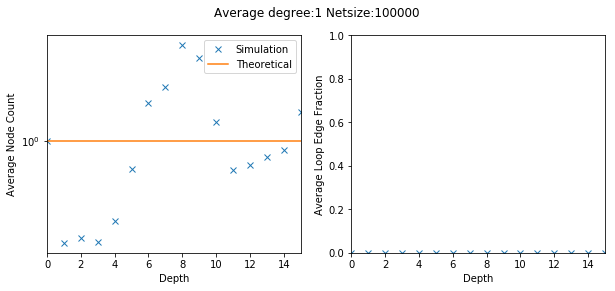

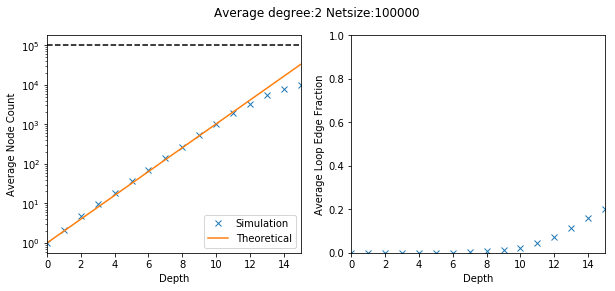

In [18]:
#Solution for b)-c):
fig = ER_breadth_first_search(0.5, 10**4, 10000)

fig = ER_breadth_first_search(1, 10**4, 10000)

fig = ER_breadth_first_search(2, 10**4, 100, show_netsize=True, max_depth=15)

fig = ER_breadth_first_search(0.5, 10**5, 10000)

fig = ER_breadth_first_search(1, 10**5, 10000)

fig = ER_breadth_first_search(2, 10**5, 100, show_netsize=True, max_depth=15)


In [19]:
dist = get_component_size_dist(g)

In [20]:
def get_susceptibility1(component_size_distribution):
    """Calculates the susceptibility (as defined in ex. 4.1e)

    Parameters
    ----------
    component_size_distribution : dict
       The component size distribution. See the function get_component_size_dist

    Returns
    -------
    Susceptibility value : float
    """
    
    numerator = 0 # Numerator value of the formula to be updated
    denominator = 0 # Denominator value of the formula to be updated
    # YOUR CODE HERE
    #TODO: Implement this function
    for component in component_size_distribution:
        numerator+=(component**2)*component_size_distribution[component]
        denominator+=component*component_size_distribution[component]
    smax = get_largest_component_size(component_size_distribution)
    numerator -= smax **2
    denominator -= smax
    return numerator/denominator

get_susceptibility1({1:4, 2: 10, 3:12, 4:1})

2.533333333333333

In [21]:
def get_susceptibility(component_size_distribution):
    """Calculates the susceptibility (as defined in ex. 4.1e)

    Parameters
    ----------
    component_size_distribution : dict
       The component size distribution. See the function get_component_size_dist

    Returns
    -------
    Susceptibility value : float
    """
    dist = component_size_distribution
    numerator = 0
    denominator = 0
    max_size = -1
    for size in dist:
        freq = dist[size]
        numerator += size**2 * freq
        denominator += size * freq
        
        if size > max_size:
            max_size = size
    
    numerator -= max_size**2
    denominator -= max_size
    
    return numerator/denominator

get_susceptibility({1:4, 2: 10, 3:12, 4:1})

2.533333333333333